In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import numpy as np
ran = fits.open('randoms_subset_combined.fits')[1].data
dat = fits.open('elg_N_combined.fits')[1].data

In [3]:
print len(ran),len(dat)

3393999 184860


In [78]:
a = set(ran['brickname'])
b = set(dat['brickname'])
bricklist = a & b
ran_cut = a-b
dat_cut = b-a
print len(a),len(ran_cut)+len(bricklist)
print len(b),len(dat_cut)+len(bricklist)

13562 13562
13315 13315


In [79]:
def brick_check(brickname,brick_cut):
    for i in range(0,len(brick_cut)):
        if brickname == brick_cut[i]:
            return True
    return False

In [80]:
ran_brickmask = np.ones(len(ran))
dat_brickmask = np.ones(len(dat))

ran_cut = list(ran_cut)
dat_cut = list(dat_cut)
for i in range(0,len(ran)):
    if brick_check(ran['brickname'][i],ran_cut):
        ran_brickmask[i]=0
        
for i in range(0,len(dat)):
    if brick_check(dat['brickname'][i],dat_cut):
        dat_brickmask[i]=0

In [81]:
ran_select = ran_brickmask[ran_brickmask == 1] 
dat_select = dat_brickmask[dat_brickmask == 1] 

In [82]:
print len(ran_select),len(ran_brickmask),len(ran)
print len(dat_select),len(dat_brickmask),len(dat)

3346023 3393999 3393999
182248 184860 184860


In [55]:
ran_brickmask[2723783]

0.0

In [91]:
from astropy.table import Column
from astropy.table import Table
col2 = Column(ran_brickmask, name='brick_mask')
tb_ran = Table.read('randoms_subset_combined.fits')
tb_ran.add_column(col2, index=0)
tb_ran.write('./randoms_subset_combined_masked.fits',overwrite = True)

In [92]:
col_dat = Column(dat_brickmask, name='brick_mask')
tb_dat = Table.read('elg_N_combined.fits')
tb_dat.add_column(col_dat, index=0)
tb_dat.write('./elg_subset_combined_masked.fits',overwrite = True)

In [4]:
ran_m = fits.open('randoms_subset_combined_masked.fits')[1].data
dat_m = fits.open('elg_subset_combined_masked.fits')[1].data

In [7]:
ran_brick = ran_m['brick_mask']
ran_om = ran_m['obiwan_mask']
Select_ran = (ran_brick==1) & (ran_om==129)
dat_brick = dat_m['brick_mask']
dat_primary = dat_m['brick_primary']
Select_dat = (dat_brick==1) & (dat_primary)

ran_final = ran_m[Select_ran]
dat_final = dat_m[Select_dat]

print len(ran_m),len(ran_final),len(dat_m),len(dat_final)

3393999 3261804 184860 182248


(23.8, 25)

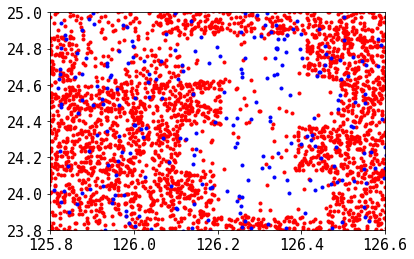

In [138]:
plt.plot(ran_final['ra'],ran_final['dec'],'r.')
plt.plot(dat_final['ra'],dat_final['dec'],'b.')
plt.gca().set_xlim((125.8,126.6))
plt.gca().set_ylim((23.8,25))

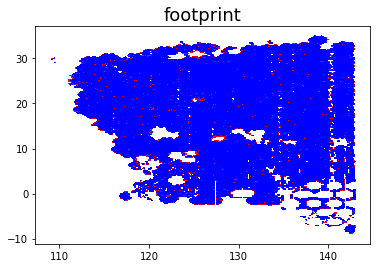

In [128]:
plt.plot(ran_final['ra'],ran_final['dec'],'r,')
plt.plot(dat_final['ra'],dat_final['dec'],'b,')
plt.rc('font',**{'size':15, 'family':'monospace'})
plt.title('footprint')

In [136]:
ran_final['obiwan_mask']

131

In [133]:
dat_final.columns

ColDefs(
    name = 'brick_mask'; format = 'D'
    name = 'release'; format = 'I'
    name = 'brickid'; format = 'J'
    name = 'brickname'; format = '8A'
    name = 'objid'; format = 'J'
    name = 'brick_primary'; format = 'L'
    name = 'type'; format = '4A'
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'ra_ivar'; format = 'E'
    name = 'dec_ivar'; format = 'E'
    name = 'bx'; format = 'E'
    name = 'by'; format = 'E'
    name = 'dchisq'; format = '5E'
    name = 'ebv'; format = 'E'
    name = 'mjd_min'; format = 'D'
    name = 'mjd_max'; format = 'D'
    name = 'flux_u'; format = 'E'
    name = 'flux_g'; format = 'E'
    name = 'flux_r'; format = 'E'
    name = 'flux_i'; format = 'E'
    name = 'flux_z'; format = 'E'
    name = 'flux_Y'; format = 'E'
    name = 'flux_w1'; format = 'E'
    name = 'flux_w2'; format = 'E'
    name = 'flux_w3'; format = 'E'
    name = 'flux_w4'; format = 'E'
    name = 'flux_ivar_u'; format = 'E'
    name = 'flux_ivar_g'; f

In [6]:
3261804./182248.

17.897612045125324

In [8]:
brick_list = set(ran_final['brickname'])
brick_list = set(dat_final['brickname'])

In [9]:
n = float(len(ran_final))/float(len(dat_final))

In [10]:
bricklist = list(brick_list)

In [13]:
def ratio_lists(index):
    ratio_n = []
    for i in index:
        NAME_RAN = ran_final['brickname']
        SEL_RAN = (NAME_RAN==bricklist[i])
        n_ran = len(ran_final[SEL_RAN])
        NAME_DAT = dat_final['brickname']
        SEL_DAT = (NAME_DAT==bricklist[i])
        n_dat = len(dat_final[SEL_DAT])
        ratio_n.append(float(n_ran)/float(n_dat)-n)
    return ratio_n

In [14]:
indexes = np.arange(len(bricklist))
index_i = np.array_split(indexes, 24)
print len(index_i),len(index_i[0]),len(bricklist),index_i[23][-1]
from multiprocessing import Pool
list_p = []
for i in range(0,24):
    list_p.append(index_i[i])

24 547 13116 13115


In [15]:
from multiprocessing import Pool
p = Pool(24)
lists = p.map(ratio_lists, list_p)

In [19]:
tot_list = np.array(lists[0])
for i in range(1,24):
    tot_list = np.hstack((tot_list,np.array(lists[i])))

### Distribution of (n$_{ran}$/n$_{gal}$)/(n$_{ran}$$^{total}$/n$_{gal}$$^{total}$)-1
it shows there's a cut at lower limit,minimum value is -0.99, but the maximum value is very big ~15

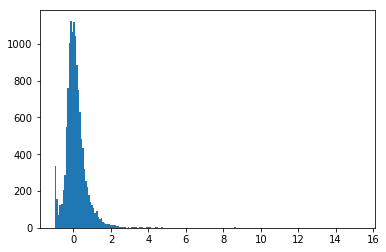

In [29]:
tot_list_norm=tot_list/float(n)
plt.hist(tot_list_norm,bins=200)
plt.show()

In [30]:
print min(tot_list_norm),max(tot_list_norm)

-0.992018089201 15.2591522973


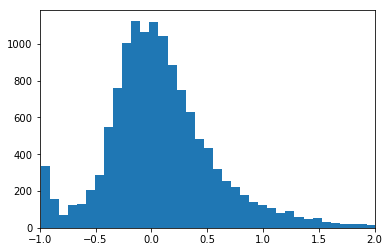

In [31]:
tot_list_norm=tot_list/float(n)
plt.hist(tot_list_norm,bins=200)
plt.gca().set_xlim((-1,2))
plt.show()